# SQL Database Pipeline #

In [15]:
import os
import pandas as pd
import sqlite3
from fredapi import Fred

FRED_API_KEY = "f4ebdf5736473073008b9f5a7ca9bd1a"  
fred = Fred(api_key=FRED_API_KEY)

# Define Treasury Yield Series
FRED_SERIES = {
    "T1M": "DGS1MO",
    "T3M": "DGS3MO",
    "T6M": "DGS6MO",
    "T1Y": "DGS1",
    "T2Y": "DGS2",
    "T5Y": "DGS5",
    "T10Y": "DGS10",
    "T30Y": "DGS30",
}

# Creates a Folder for CSVs 
csv_folder = "treasury_data"
os.makedirs(csv_folder, exist_ok=True)

# Fetchs Data and Saves Each Maturity as CSV
for maturity, series_id in FRED_SERIES.items():
    df = fred.get_series(series_id).reset_index()
    df.columns = ["date", "yield"]  # Standardize column names
    df["date"] = df["date"].astype(str)  # Ensure date is string for SQLite
    file_path = os.path.join(csv_folder, f"{maturity}_Treasury.csv")
    df.to_csv(file_path, index=False)
    print(f"Saved {maturity} data to {file_path}")

Saved T1M data to treasury_data/T1M_Treasury.csv
Saved T3M data to treasury_data/T3M_Treasury.csv
Saved T6M data to treasury_data/T6M_Treasury.csv
Saved T1Y data to treasury_data/T1Y_Treasury.csv
Saved T2Y data to treasury_data/T2Y_Treasury.csv
Saved T5Y data to treasury_data/T5Y_Treasury.csv
Saved T10Y data to treasury_data/T10Y_Treasury.csv
Saved T30Y data to treasury_data/T30Y_Treasury.csv


In [17]:
import glob

# Connect to SQLite Database 
db_path = "yields.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS BondYields")

# Create `BondYields` Table with All Maturities
columns = ["date TEXT PRIMARY KEY"] + [f"{maturity} REAL" for maturity in FRED_SERIES.keys()]
cursor.execute(f"""
    CREATE TABLE BondYields (
        {', '.join(columns)}
    )
""")
conn.commit()

# Imports CSVs into SQLite Database
csv_files = glob.glob(os.path.join(csv_folder, "*_Treasury.csv"))

for file in csv_files:
    maturity = os.path.basename(file).split("_")[0]
    df = pd.read_csv(file)
    df = df.rename(columns={"yield": maturity})  # Rename yield column
    df["date"] = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")

    # Inserts new rows into BondYields
    for _, row in df.iterrows():
        cursor.execute(f"""
            INSERT OR IGNORE INTO BondYields (date) VALUES (?)
        """, (row["date"],))

        cursor.execute(f"""
            UPDATE BondYields
            SET {maturity} = ?
            WHERE date = ?
        """, (row[maturity], row["date"]))

conn.commit()

# Close the Database Connection
conn.close()
print("Database update complete.")

Database update complete.


In [18]:
# Load and Melt the Data
conn = sqlite3.connect(db_path)

# Load the BondYields table
df = pd.read_sql("SELECT * FROM BondYields", conn)

# Melt into long format
melted_df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")

melted_df = melted_df.dropna()

# Display the DataFrame
display(melted_df) 

conn.close()

,date,maturity,yield
6380,2001-07-31,T1M,3.67
6381,2001-08-01,T1M,3.65
6382,2001-08-02,T1M,3.65
6383,2001-08-03,T1M,3.63
6384,2001-08-06,T1M,3.62
...,...,...,...
127762,2025-02-03,T30Y,4.77
127763,2025-02-04,T30Y,4.75
127764,2025-02-05,T30Y,4.64
127765,2025-02-06,T30Y,4.65


In [19]:
with sqlite3.connect("yields.db") as conn:
    df = pd.read_sql_query('SELECT * FROM BondYields;', conn)
    df = df.dropna()
    df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")
df

,date,maturity,yield
0,2001-07-31,T1M,3.67
1,2001-08-01,T1M,3.65
2,2001-08-02,T1M,3.65
3,2001-08-03,T1M,3.63
4,2001-08-06,T1M,3.62
...,...,...,...
47059,2025-02-03,T30Y,4.77
47060,2025-02-04,T30Y,4.75
47061,2025-02-05,T30Y,4.64
47062,2025-02-06,T30Y,4.65


In [20]:
import plotly.express as px

In [21]:
def query_yield_curve(db_file, start_date, end_date):
    conn = sqlite3.connect(db_file)
    
    # Writes the SQL query using f-strings
    query = f"""
        SELECT *
        FROM BondYields
        WHERE date BETWEEN '{start_date}' AND '{end_date}'
    """
    
    df=pd.read_sql_query(query, conn)
    df = df.dropna()
    df = df.melt(id_vars=["date"], var_name="maturity", value_name="yield")
    conn.close()
    
    return df

In [22]:
def plot_yields(db_file, start_date, end_date):
    
    df = query_yield_curve(db_file, start_date, end_date)
    
    fig = px.line(df, x="maturity", y="yield", color="date",
                  title=f"Treasury Yield Curve ({start_date} to {end_date})",
                  labels={"maturity": "Maturity", "yield": "Yield (%)"},
                  markers=True)
    
    return fig

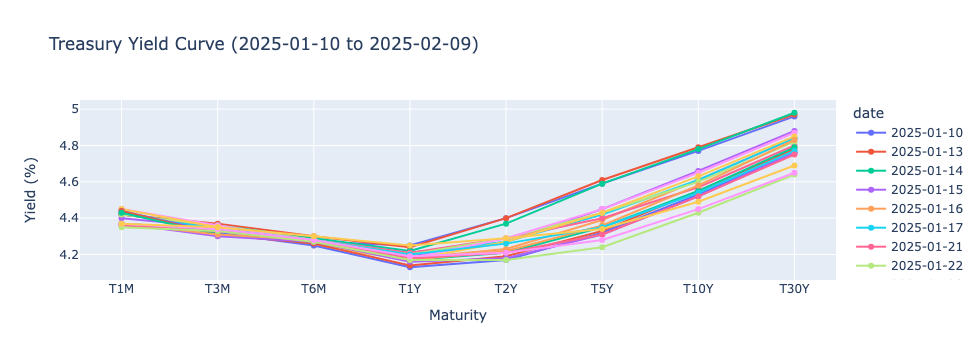

In [25]:
fig = plot_yields(db_file = "yields.db",
            start_date = "2025-01-10",
            end_date = "2025-02-09")

fig.show()

In [53]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [70]:
def forecast_treasury_rates(csv_path, forecast_periods=30, time_horizon="6M"):
    """
    Reads a Treasury rate CSV, handles missing data, applies ARIMA forecasting,
    and plots the results using Plotly.
    """

    # Load the dataset
    df = pd.read_csv(csv_path, parse_dates=["date"])
    df.set_index("date", inplace=True)
    
    df = df.asfreq("B")

    # Handle missing data (forward fill, then interpolate remaining gaps)
    df["yield"] = df["yield"].ffill().interpolate()

    # Auto ARIMA model selection
    model = auto_arima(df["yield"], seasonal=True, stepwise=True, suppress_warnings=True, m=12)
    
    # Fit the best ARIMA model
    arima_model = sm.tsa.ARIMA(df["yield"], order=model.order).fit()

    # Forecast future values
    forecast_index = pd.date_range(start=df.index[-1], periods=forecast_periods+1, freq="B")[1:]
    forecast_values = arima_model.forecast(steps=forecast_periods)

    # Create a DataFrame for the forecast
    forecast_df = pd.DataFrame({"yield": forecast_values}, index=forecast_index)

    # Concatenate actual & forecasted data
    df_combined = pd.concat([df, forecast_df])

    # Limit time horizon for visualization
    df_filtered = df_combined.last(time_horizon)

    # Create Plotly figure
    fig = go.Figure()

    # Actual data trace
    fig.add_trace(go.Scatter(
        x=df_filtered.index, 
        y=df_filtered["yield"],
        mode="lines",
        name="Actual Yield",
        line=dict(color="lightblue")
    ))

    # Forecast data trace
    fig.add_trace(go.Scatter(
        x=forecast_df.index, 
        y=forecast_df["yield"],
        mode="lines",
        name="Forecast",
        line=dict(color="red", dash="dot")
    ))

    # Update layout
    fig.update_layout(
        title="Short-Term Treasury Rate Forecast (ARIMA)",
        xaxis_title="Date",
        yaxis_title="Yield (%)",
        template="plotly_white",
        xaxis=dict(range=[df_filtered.index.min(), df_filtered.index.max()])
    )

    # Show plot
    return fig

In [ ]:
fig = forecast_treasury_rates("T1Y_Treasury.csv", 
                              forecast_periods=30, 
                              time_horizon="6M")
fig.show()

In [58]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["yield"])
print("p-value:", result[1])  # If p > 0.05, the data is non-stationary

p-value: 0.21474651742188788


In [59]:
result = adfuller(np.log(df["yield"]))
print("p-value:", result[1])  # If p > 0.05, the data is non-stationary

p-value: 0.34611151135178864


In [63]:
df = pd.read_csv("T1Y_Treasury.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# Handle missing data
df["yield"] = df["yield"].ffill().interpolate()
    
df["yield_diff"] = df["yield"].diff().dropna()

df

,yield,yield_diff
date,,
1962-01-02,3.22,NaN
1962-01-03,3.24,0.02
1962-01-04,3.24,0.00
1962-01-05,3.26,0.02
1962-01-08,3.31,0.05
...,...,...
2025-02-03,4.20,0.03
2025-02-04,4.18,-0.02
2025-02-05,4.17,-0.01


In [64]:
result = adfuller(df["yield_diff"].dropna())  # Drop NaN from first differencing
print("p-value after differencing:", result[1])

p-value after differencing: 0.0


In [65]:
auto_model = auto_arima(df["yield"].diff().dropna(), 
                        seasonal=False, stepwise=True, trace=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-37628.548, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-37419.894, Time=0.47 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-37570.016, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-37559.310, Time=0.51 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-37583.573, Time=0.72 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-37585.068, Time=0.69 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-37664.685, Time=3.38 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-37582.642, Time=0.95 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-37675.007, Time=3.40 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-37689.144, Time=3.15 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-37598.075, Time=0.97 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-37688.361, Time=4.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-37584.382, Time=0.83 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-37605.038, Time=1.89 sec
 ARIM